# Azure AI Search with LangChain and Ragas

This code demonstrates how to use Azure AI Search with OpenAI, Ragas, and Langchain. We will use [Ragas](https://docs.ragas.io/en/latest/index.html) to evaluate a [Langchain AI Search vector store](https://python.langchain.com/v0.1/docs/integrations/vectorstores/azuresearch/) on the following metrics:

1. [Context Precision](https://docs.ragas.io/en/latest/concepts/metrics/context_precision.html) - whether the chunks relevant to answer the question are present in the context and ranked highly.
1. [Context Recall](https://docs.ragas.io/en/latest/concepts/metrics/context_recall.html) - whether the retrieved chunks align with the ground truth answer in our evaluation test set of questions.

The notebook covers the following tasks:
1. Setup a sample data source using [integrated vectorization](https://learn.microsoft.com/en-us/azure/search/vector-search-integrated-vectorization). The [skillset](https://learn.microsoft.com/en-us/azure/search/cognitive-search-working-with-skillsets) uses two embedding models for our evaluation: [text-embedding-ada-002 and text-embedding-3-large](https://learn.microsoft.com/azure/ai-services/openai/concepts/models#embeddings)
1. Sets up multiple [basic LangChain RAG pipelines](https://python.langchain.com/v0.1/docs/modules/chains/) to answer questions. These pipelines are customized to compare the following factors during evaluation:
  1. What kind of embedding model are we using? text-embedding-ada-002 or text-embedding-3-large?
  1. What search method are we using? [Vector search](https://learn.microsoft.com/azure/search/vector-search-overview), [hybrid search](https://learn.microsoft.com/azure/search/hybrid-search-overview), or [hybrid search with semantic reranking](https://learn.microsoft.com/azure/search/semantic-search-overview)?
1. Graphs the comparison using the Context Precision and Context Recall metrics to compare the various embedding models and search methods.

### Set up a Python virtual environment in Visual Studio Code

1. Open the Command Palette (Ctrl+Shift+P).
1. Search for **Python: Create Environment**.
1. Select **Venv**.
1. Select a Python interpreter. Choose 3.10 or later.

It can take a minute to set up. If you run into problems, see [Python environments in VS Code](https://code.visualstudio.com/docs/python/environments).

### Install packages

If you get an OS permission error, add `--user` to the command line.

In [12]:
! pip install -r ragas-requirements.txt --quiet

### Load .env file

Copy `/code/.env-sample` to an `.env` file in the sample folder, and update accordingly. The search service and Azure OpenAI resource and model must exist, but the search index is created and loaded during code execution. Provide a unique name for the index. Endpoints and API keys can be found in the Azure portal.

In [1]:
from dotenv import load_dotenv
from azure.identity import DefaultAzureCredential
import os
from azure.search.documents.indexes import SearchIndexClient, SearchIndexerClient

load_dotenv(override=True) # take environment variables from .env.

# Variables not used here do not need to be updated in your .env file
endpoint = os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"]
key_credential = os.environ["AZURE_SEARCH_ADMIN_KEY"] if len(os.environ["AZURE_SEARCH_ADMIN_KEY"]) > 0 else None
index_name = os.getenv("AZURE_SEARCH_INDEX", "ragas-eval")
azure_openai_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
azure_openai_key = os.environ["AZURE_OPENAI_KEY"] if len(os.environ["AZURE_OPENAI_KEY"]) > 0 else None
azure_openai_ada002_embedding_deployment = os.environ["AZURE_OPENAI_ADA002_EMBEDDING_DEPLOYMENT"]
azure_openai_3_large_embedding_deployment = os.environ["AZURE_OPENAI_3_LARGE_EMBEDDING_DEPLOYMENT"]
azure_openai_api_version = os.environ["AZURE_OPENAI_API_VERSION"]
azure_openai_critic_deployment = os.environ["AZURE_OPENAI_CRITIC_DEPLOYMENT"]
azure_openai_generator_deployment = os.environ["AZURE_OPENAI_CRITIC_DEPLOYMENT"]
blob_connection_string = os.environ["BLOB_CONNECTION_STRING"]
# search blob datasource connection string is optional - defaults to blob connection string
# This field is only necessary if you are using MI to connect to the data source
# https://learn.microsoft.com/azure/search/search-howto-indexing-azure-blob-storage#supported-credentials-and-connection-strings
search_blob_connection_string = os.getenv("SEARCH_BLOB_DATASOURCE_CONNECTION_STRING", blob_connection_string)
blob_container_name = os.getenv("BLOB_CONTAINER_NAME", "ragas-eval")
credential = key_credential or DefaultAzureCredential()

indexer_client = SearchIndexerClient(endpoint, credential)
index_client = SearchIndexClient(endpoint, credential)

## Setup sample data

For integrated vectorization to work, make sure the sample documents have been uploaded to your blob storage account

In [2]:
from lib.utils import upload_sample_documents

upload_sample_documents(
    blob_connection_string=blob_connection_string,
    blob_container_name=blob_container_name,
    # Set to false if you want to use credentials included in the blob connection string
    # Otherwise your identity will be used as credentials
    use_user_identity=True
)
print(f"Setup sample data in {blob_container_name}")

Setup sample data in ragas-eval


## Setup integrated vectorization

Create a data source, skillset, index, and indexer to start the integrated vectorization process.
The skillset vectorizes the data twice, once using text-embedding-ada-002 and again using text-embedding-3-large. The vectors are sent to different fields to enable comparison later on in the notebook.

In [2]:
from lib.utils import create_sample_index, create_sample_datasource, create_sample_skillset, create_sample_indexer

# Create a data source 
datasource_result = create_sample_datasource(
    indexer_client,
    blob_container_name,
    index_name,
    search_blob_connection_string
)
print(f"Data source '{datasource_result.name}' created")

# Create a index
index = create_sample_index(
    index_client,
    index_name,
    azure_openai_endpoint,
    azure_openai_ada002_embedding_deployment,
    azure_openai_3_large_embedding_deployment,
    azure_openai_key)
print(f"Index {index.name} created")

# Create a skillset
skillset = create_sample_skillset(
    indexer_client,
    index_name,
    azure_openai_endpoint,
    azure_openai_ada002_embedding_deployment,
    azure_openai_3_large_embedding_deployment,
    azure_openai_key
)
print(f"Skillset {skillset.name} created")

# Create an run an indexer
indexer = create_sample_indexer(
    indexer_client,
    index.name,
    skillset.name,
    datasource_result.name
)
print(f'{indexer.name} is created and running. If queries return no results, please wait a bit and try again.')  


Data source 'ragas-eval-blob' created
Index ragas-eval created
Skillset ragas-eval-skillset created
ragas-eval-indexer is created and running. If queries return no results, please wait a bit and try again.


## Initialize LangChain LLMs and embeddings

In order for evaluation to work, we need the following:

1. A LangChain embedding model for text-embedding-ada-002
1. A LangChain embedding model for text-embedding-3-large
1. A "critic" LLM used for judging our metrics. [gpt-4o](https://learn.microsoft.com/azure/ai-services/openai/concepts/models#gpt-4o-and-gpt-4-turbo) can be used as the critic.
1. A "generator" LLM used for generating text. [gpt-35-turbo](https://learn.microsoft.com/azure/ai-services/openai/concepts/models#gpt-35) can be used as the generator.

In [3]:
from lib.utils import create_langchain_azure_openai_wrappers

text_3_large_embeddings, ada_002_embeddings, generator_llm, critic_llm = create_langchain_azure_openai_wrappers(
    azure_openai_api_version,
    azure_openai_endpoint,
    azure_openai_3_large_embedding_deployment,
    azure_openai_ada002_embedding_deployment,
    azure_openai_generator_deployment,
    azure_openai_critic_deployment,
    azure_openai_key
)

## Generate the test data set

We can use [Ragas](https://docs.ragas.io/en/latest/getstarted/testset_generation.html) to generate a synthetic data set for evaluating our RAG pipeline from a sample of documents in your normal data set. The synthetic data set includes questions and answers generated from those documents.

We have provided a [pre-generated test set](../../../data/evalquestions/ragas/testset.json) because generating test data may take a long time. You can use the provided code to generate a new test set based on your own data.

In [ ]:
import pandas as pd
from datasets import Dataset
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_community.document_loaders import PyPDFDirectoryLoader

documents_directory = os.path.join("..", "..", "..", "..", "data", "benefitdocs")
test_dataset_path = os.path.join("..", "..", "..", "..", "data", "evalquestions", "ragas", "testset.json")
if os.path.exists(test_dataset_path):
    # Use a pre-generated test dataset by default
    test_dataset = pd.read_json(test_dataset_path)
    test_dataset = Dataset.from_pandas(test_dataset)
else:
    # The following code generates a synthetic data set based on a set of PDF documents in the sample directory
    loader = PyPDFDirectoryLoader(path=documents_directory, glob="*.pdf")
    documents = loader.load()

    generator = TestsetGenerator.from_langchain(
        generator_llm,
        critic_llm,
        text_3_large_embeddings
    )

    # Change resulting question type distribution
    # https://docs.ragas.io/en/latest/concepts/testset_generation.html
    distributions = {
        simple: 0.5,
        multi_context: 0.4,
        reasoning: 0.1
    }

    test_dataset = generator.generate_with_langchain_docs(documents, test_size=10, distributions=distributions) 
    test_dataset = test_dataset.to_dataset()

## Create RAG chains and evaluate them

The following code demonstrates how to create a simple RAG chain in Langchain using the AI Search vector retriever, and then evaluate them using various RAGAS metrics. By default, Context Recall and Context Precision are used.

In [9]:
from langchain.llms.base import BaseLLM
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.vectorstores import VectorStore
from datasets import Dataset
from langchain.embeddings.base import Embeddings
from ragas.metrics import (
    ContextPrecision,
    ContextRecall
)
from ragas.metrics.base import Metric
from ragas.llms import LangchainLLMWrapper
from ragas import evaluate
from langchain_core.runnables import Runnable
from typing import Optional, List

def create_rag_chain(generator_llm: BaseLLM, vectorstore: VectorStore):
    system_prompt = (
        "Use the given context to answer the question. "
        "If you don't know the answer, say you don't know. "
        "Use three sentence maximum and keep the answer concise. "
        "Context: {context}"
    )
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "{input}"),
        ]
    )
    question_answer_chain = create_stuff_documents_chain(generator_llm, prompt)
    return create_retrieval_chain(vectorstore.as_retriever(), question_answer_chain)

def evaluate_rag_chain(test_dataset: Dataset, critic_llm: BaseLLM, embeddings: Embeddings, rag_chain: Runnable, metrics: Optional[List[Metric]] = None):
    predictions = rag_chain.batch([{"input": question} for question in test_dataset["question"]])
    eval_dataset = Dataset.from_list(
    [
        {
            "question": test_dataset[i]["question"],
            "contexts": [context.page_content for context in prediction["context"]],
            "answer": prediction["answer"],
            "ground_truth": test_dataset[i]["ground_truth"]
        } for i, prediction in enumerate(predictions)
    ])
    metrics = metrics or [
        ContextPrecision(LangchainLLMWrapper(critic_llm)),
        ContextRecall(LangchainLLMWrapper(critic_llm)),
    ]
    return evaluate(
        dataset=eval_dataset,
        metrics=metrics,
        llm=critic_llm,
        embeddings=embeddings)

## Evaluate text-embedding-ada-002 context recall and precision

Use the evaluation and chain creation methods we created in the previous cell to run the evaluation

In [10]:
from lib.utils import create_langchain_vectorstore

ada_002_qa = create_rag_chain(
    generator_llm=generator_llm,
    vectorstore=create_langchain_vectorstore(
        azure_search_endpoint=endpoint,
        azure_search_key=key_credential,
        index_name=index_name,
        embedding_function=ada_002_embeddings.embed_query,
        vector_field_name="vector_ada002"
    )
)

ada_002_eval = evaluate_rag_chain(
    test_dataset,
    critic_llm,
    ada_002_embeddings,
    ada_002_qa)

ada_002_eval

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

{'context_precision': 0.7333, 'context_recall': 0.7488}

## Evaluate text-embedding-3-large context recall and precision

Use the evaluation and chain creation methods we created in the previous cell to run the evaluation

In [11]:
from lib.utils import create_langchain_vectorstore

text_3_large_qa = create_rag_chain(
    generator_llm=generator_llm,
    vectorstore=create_langchain_vectorstore(
        azure_search_endpoint=endpoint,
        azure_search_key=key_credential,
        index_name=index_name,
        embedding_function=text_3_large_embeddings.embed_query,
        vector_field_name="vector_3_large"
    )
)

text_3_large_eval = evaluate_rag_chain(
    test_dataset,
    critic_llm,
    text_3_large_embeddings,
    text_3_large_qa)

text_3_large_eval

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

{'context_precision': 0.7389, 'context_recall': 0.8714}

## Visualize the results

Use matplotlib to graph the two metrics together for comparison. We can see that text-embedding-3-large has superior context recall on the test set compared to text-embedding-ada-002

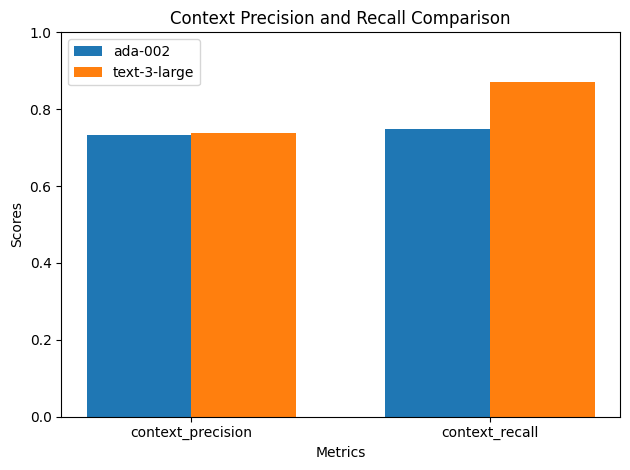

In [14]:
import matplotlib.pyplot as plt
import numpy as np
labels = list(ada_002_eval.keys())
ada_002_values = list(ada_002_eval.values())
text_3_large_values = list(text_3_large_eval.values())

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Plotting
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ada_002_values, width, label='ada-002')
rects2 = ax.bar(x + width/2, text_3_large_values, width, label='text-3-large')

# Adding labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Context Precision and Recall Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()

fig.tight_layout()
plt.show()

## Evaluate search methods on text-embedding-ada-003

Further evaluate text-embedding-ada-003 by comparing various search methods: vector (similarity), hybrid, and hybrid with semantic reranking search.

In [15]:
from lib.utils import create_langchain_vectorstore

similarity_search_qa = create_rag_chain(
    generator_llm=generator_llm,
    vectorstore=create_langchain_vectorstore(
        azure_search_endpoint=endpoint,
        azure_search_key=key_credential,
        index_name=index_name,
        embedding_function=text_3_large_embeddings.embed_query,
        vector_field_name="vector_3_large",
        search_type="similarity"
    )
)

similarity_eval = evaluate_rag_chain(
    test_dataset,
    critic_llm,
    text_3_large_embeddings,
    similarity_search_qa)

similarity_eval

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

{'context_precision': 0.7389, 'context_recall': 0.8667}

In [16]:
from lib.utils import create_langchain_vectorstore

hybrid_search_qa = create_rag_chain(
    generator_llm=generator_llm,
    vectorstore=create_langchain_vectorstore(
        azure_search_endpoint=endpoint,
        azure_search_key=key_credential,
        index_name=index_name,
        embedding_function=text_3_large_embeddings.embed_query,
        vector_field_name="vector_3_large",
        search_type="hybrid"
    )
)

hybrid_eval = evaluate_rag_chain(
    test_dataset,
    critic_llm,
    text_3_large_embeddings,
    hybrid_search_qa)

hybrid_eval

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

{'context_precision': 0.7389, 'context_recall': 0.8714}

In [17]:
from lib.utils import create_langchain_vectorstore

hybrid_semantic_search_qa = create_rag_chain(
    generator_llm=generator_llm,
    vectorstore=create_langchain_vectorstore(
        azure_search_endpoint=endpoint,
        azure_search_key=key_credential,
        index_name=index_name,
        embedding_function=text_3_large_embeddings.embed_query,
        vector_field_name="vector_3_large",
        search_type="hybrid_semantic"
    )
)

hybrid_semantic_eval = evaluate_rag_chain(
    test_dataset,
    critic_llm,
    text_3_large_embeddings,
    hybrid_semantic_search_qa)

hybrid_semantic_eval

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

{'context_precision': 0.7389, 'context_recall': 0.8714}

## Visualize the results

Graph context recall and context precision for the 3 search methods. Hybrid semantic has the best recall, while all the search methods are tied for precision.

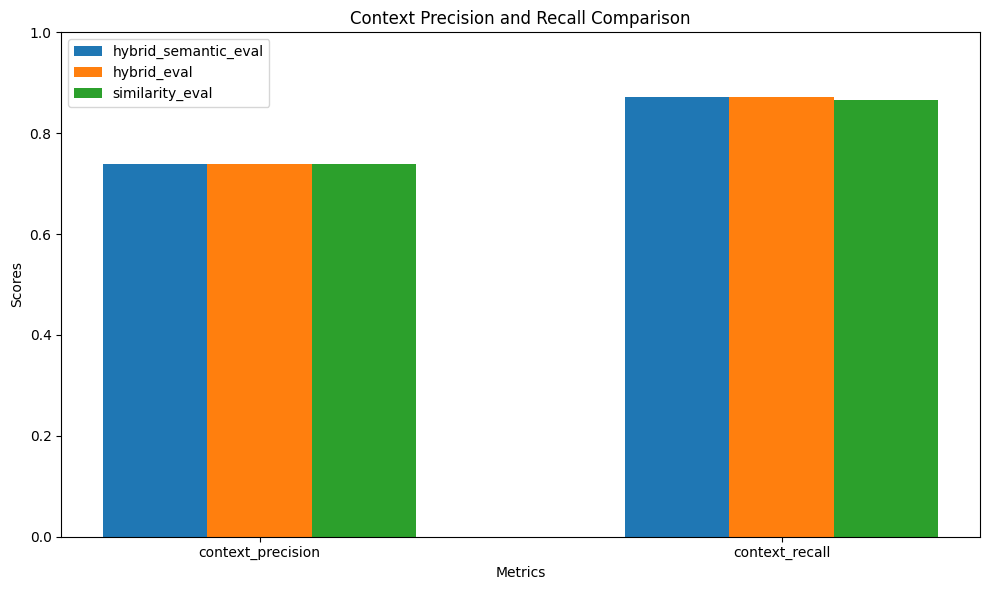

In [18]:
# Data preparation
labels = list(hybrid_semantic_eval.keys())
hybrid_semantic_values = list(hybrid_semantic_eval.values())
hybrid_values = list(hybrid_eval.values())
similarity_values = list(similarity_eval.values())

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, hybrid_semantic_values, width, label='hybrid_semantic_eval')
rects2 = ax.bar(x, hybrid_values, width, label='hybrid_eval')
rects3 = ax.bar(x + width, similarity_values, width, label='similarity_eval')

# Adding labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Context Precision and Recall Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()

fig.tight_layout()
plt.show()